In [240]:
import netket as nk
import flax.linen as nn

import jax
import jax.numpy as jnp

import scipy as sp
import matplotlib.pyplot as plt
import time, json

In [223]:
L = 16
chain= nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hilbert = nk.hilbert.Spin(s=0.5, total_sz=0, N=chain.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=chain)
evals = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -28.569185442467127


In [229]:
L = 4
chain= nk.graph.Hypercube(length=L, n_dim=2, pbc=True)
hilbert = nk.hilbert.Spin(s=0.5, total_sz=0, N=chain.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=chain)
evals = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -44.913932833715464


In [230]:
rbm = nk.models.RBM(alpha=1)

sampler = nk.sampler.MetropolisExchange(hilbert=hilbert,graph=chain)
optim = nk.optimizer.Sgd(learning_rate=0.05)
sr = nk.optimizer.SR(diag_shift=0.1)
var_state = nk.vqs.MCState(sampler, rbm, n_samples=1008)

ground_state = nk.VMC(
    hamiltonian=hamiltonian,
    optimizer=optim,
    preconditioner=sr,
    variational_state=var_state)

start = time.time()
ground_state.run(out='RBM', n_iter=100)
end = time.time()

print('### RBM calculation')
print('Has',var_state.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

data=json.load(open("RBM.log"))
   
# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]

100%|██████████| 100/100 [00:04<00:00, 22.60it/s, Energy=-44.547 ± 0.098 [σ²=9.702, R̂=1.0070]]

### RBM calculation
Has 288 parameters
The RBM calculation took 4.474529504776001 seconds


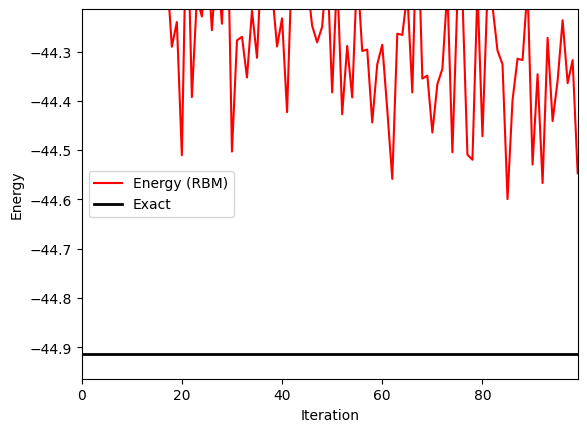

In [231]:
data=json.load(open("RBM.log"))
   
# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]
    
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.05,exact_gs_energy+0.7])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [232]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=2*x.shape[-1], 
            param_dtype=jnp.complex128, 
            kernel_init=nn.initializers.normal(stddev=0.1), 
            bias_init=nn.initializers.normal(stddev=0.1)
        )(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)
    
ffnn = FFNN()

sampler = nk.sampler.MetropolisExchange(hilbert, graph=chain)

# The variational state
var_state = nk.vqs.MCState(sampler, ffnn, n_samples=1008)

optim = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)

# The ground-state optimization loop
ground_state = nk.VMC(
    hamiltonian=hamiltonian,
    optimizer=optim,
    preconditioner=sr,
    variational_state=var_state)


start = time.time()
ground_state.run(out='FF', n_iter=100)
end = time.time()

print('### Feed Forward calculation')
print('Has',var_state.n_parameters,'parameters')
print('The Feed Forward calculation took',end-start,'seconds')

100%|██████████| 100/100 [00:14<00:00,  6.71it/s, Energy=-44.639-0.062j ± 0.074 [σ²=5.522, R̂=1.0090]]

### Feed Forward calculation
Has 544 parameters
The Feed Forward calculation took 16.409237384796143 seconds


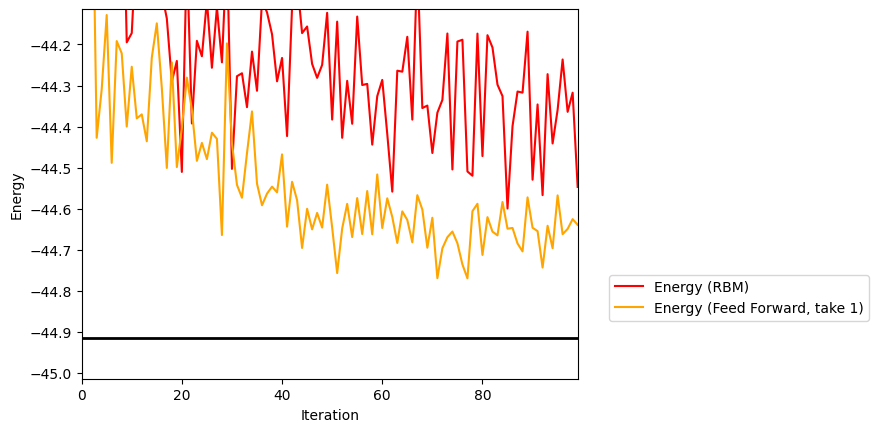

In [233]:
# import the data from log file
data=json.load(open("FF.log"))

# Extract the relevant information
iters_FF = data["Energy"]["iters"]
energy_FF = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_RBM, energy_RBM, color='red',label='Energy (RBM)')
ax1.plot(iters_FF, energy_FF, color='orange',label='Energy (Feed Forward, take 1)')
ax1.legend(bbox_to_anchor=(1.05, 0.3))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_FF[-1],exact_gs_energy-0.1,exact_gs_energy+0.8])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()

In [234]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Reshape to 2D grid (4x4 for L=4)
        
        x = jnp.reshape(x, (-1, int(4), int(4), 1))  # (batch, 4, 4, 1)
        
        # Conv2D layers for 2D correlations
        x = nn.Conv(
            features=16,
            kernel_size=(3, 3),
            padding='SAME',
            param_dtype=jnp.complex128,
            kernel_init=nn.initializers.normal(stddev=0.1)
        )(x)
        x = nk.nn.activation.log_cosh(x)
        
        x = nn.Conv(
            features=32,
            kernel_size=(3, 3),
            padding='SAME',
            param_dtype=jnp.complex128
        )(x)
        x = nk.nn.activation.log_cosh(x)
        
        # Aggregate spatial info
        x = jnp.sum(x, axis=(1, 2))  # Sum over spatial dimensions
        x = nn.Dense(1, param_dtype=jnp.complex128)(x)
        return x.squeeze()

# Instantiate the CNN
cnn = CNN()

sampler = nk.sampler.MetropolisExchange(hilbert, graph=chain)

# The variational state with CNN
var_state = nk.vqs.MCState(sampler, cnn, n_samples=1008)

optim = nk.optimizer.Sgd(learning_rate=0.05)
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)

# The ground-state optimization loop with CNN
ground_state = nk.VMC(
    hamiltonian=hamiltonian,
    optimizer=optim,
    preconditioner=sr,
    variational_state=var_state)

start = time.time()
ground_state.run(out='CNN', n_iter=100)
end = time.time()

print('### Convolutional Neural Network calculation')
print('Has', var_state.n_parameters, 'parameters')
print('The CNN calculation took', end - start, 'seconds')

100%|██████████| 100/100 [16:55<00:00, 10.16s/it, Energy=-44.818+0.022j ± 0.055 [σ²=3.098, R̂=1.0019]]

### Convolutional Neural Network calculation
Has 4833 parameters
The CNN calculation took 1023.4697391986847 seconds


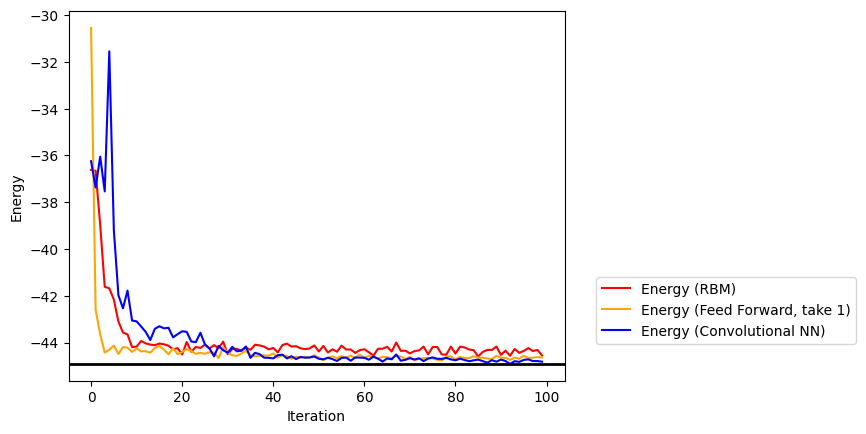

In [236]:
# import the data from log file
data=json.load(open("CNN.log"))

# Extract the relevant information
iters_CNN = data["Energy"]["iters"]
energy_CNN = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_RBM, energy_RBM, color='red',label='Energy (RBM)')
ax1.plot(iters_FF, energy_FF, color='orange',label='Energy (Feed Forward, take 1)')
ax1.plot(iters_CNN, energy_CNN, color='blue',label='Energy (Convolutional NN)')

ax1.legend(bbox_to_anchor=(1.05, 0.3))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
# plt.axis([0,iters_FF[-1],exact_gs_energy-0.1,exact_gs_energy+0.8])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()

In [238]:
all_states = hilbert.all_states()
log_psi = var_state.log_value(all_states)  # Correct method name
psi = jnp.exp(log_psi)

# Normalize the state
norm = jnp.sqrt(jnp.sum(jnp.abs(psi)**2))
psi_normalized = psi / norm

print("Reconstructed state shape:", psi_normalized.shape)

Reconstructed state shape: (12870,)


In [239]:
E_avg = var_state.expect(hamiltonian)
print("Variational energy:", E_avg)

_, evecs = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=True)
exact_psi = evecs[:, 0]
overlap = jnp.abs(jnp.vdot(psi_normalized, exact_psi))
print("Overlap with exact GS:", overlap)

Variational energy: -44.749-0.003j ± 0.056 [σ²=3.205, R̂=1.0101]
Overlap with exact GS: 0.9974689593907394
